# Predicting the Outcome of Professional Overwatch Matches Based on Player Performance
We will be looking at Overwatch League matches from 2020 and predicting the match results of 2021 matches. 

In [58]:
import psycopg2
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [4]:
def create_cursor():
    pg_conn = psycopg2.connect(
        host='localhost',
        port=5432,
        database= 'postgres',
        user = 'postgres',
        password = '9543'
    )
    return pg_conn.cursor()


In [5]:
cur = create_cursor()

In [6]:
cur.execute("SELECT COUNT(DISTINCT match_id) from public.match_data WHERE round_start_time >= '1.1.2020 00:00:00' AND round_start_time < '1.1.2021 00:00:00'")
total_match_data = cur.fetchall()[0][0]
cur.execute("SELECT COUNT(DISTINCT esports_match_id) from public.player_data_2020")
total_player_data = cur.fetchall()[0][0]
cur.execute("SELECT COUNT(DISTINCT stat_name) from public.player_data_2020")
total_stat_names = cur.fetchall()[0][0]

print(f"We have match data for {total_match_data} total matches in the 2020 OWL season.")
print(f"We have player data for {total_player_data} of those matches.")
print(f"There are {total_stat_names} features that we could use to train our model.")

We have match data for 296 total matches in the 2020 OWL season.
We have player data for 256 of those matches.
There are 360 features that we could use to train our model.


We should try and reduce the number of features by eliminating ones that tend to not affect match outcomes as much as others. The interesting part about the player stats in this dataset is that there are some that are unique to certain heroes (e.g "Freeze Spray Damage" for Mei). It will be hard to use these hero-specific features because teams do not always run the same heroes. We cannot exactly compare the "Freeze Spray Damage" to another team if they do not have a Mei. Therefore, we will stick with the features which apply to all heroes. Now, we can remove even more features by looking which features have the least correlation with the target feature. However, we'll need to restructure the data quite a bit to do this. 

In [7]:
# Get all features (hero stats + match id + team + target variable)
cur.execute("""
SELECT DISTINCT stat_name
FROM public.player_data_2020
WHERE hero_name = 'All Heroes' """)

all_hero_stats = [stat[0] for stat in cur.fetchall()]
all_hero_stats= sorted(all_hero_stats)
cols = ['match_id', 'team_one', 'team_two', 'w_l']
cols.extend(all_hero_stats)
print(len(cols))

40


In [13]:
# Returns the winning team of a match
def find_winner(match_id):
    cur.execute(f"""
    SELECT match_winner
    FROM public.match_data
    WHERE match_id = {match_id}
    LIMIT 1
    """)
    return cur.fetchall()[0][0]

# Returns a tuple of the two teams that plyaed in the match. Order is random
def find_teams(match_id):
    cur.execute(f"""
    SELECT team_one_name, team_two_name
    FROM public.match_data
    WHERE match_id = {match_id}
    LIMIT 1
    """)
    return cur.fetchall()[0]


# Returns a list of 36 average "all heroes" stats for a specific team during a specific match
def find_avg_stats(match_id, team, yr):
    cur.execute(f"""
    SELECT DISTINCT stat_name, AVG(stat_amount)
    FROM public.player_data_{yr}
    WHERE   hero_name= 'All Heroes' AND  
            esports_match_id = {match_id} AND 
            team_name = '{team}'
    GROUP BY stat_name
    ORDER BY stat_name
    """)
    stats_dict = dict.fromkeys(all_hero_stats, None)
    for stat_name, stat_avg in cur.fetchall():
        if stat_name in stats_dict.keys():
            stats_dict[stat_name] = stat_avg
    
    return stats_dict.values()

# Finds the difference in the team's average stats and returns as a list. 
def find_avg_stats_diff(match_id, team_1, team_2, yr):
    zipped = zip(find_avg_stats(match_id, team_1, yr), find_avg_stats(match_id, team_2, yr))
    avg_stats_diff = []
    for stat_team_1, stat_team_2 in zipped:
        if stat_team_1 and stat_team_2:
            avg_stats_diff.append(round(stat_team_1 - stat_team_2, 2))
        else:
            avg_stats_diff.append('Null')
    return avg_stats_diff

# Returns a row's worth (an observation of one match) of data for the dataframe.
def get_match_data(match_id, yr):
    team_1, team_2 = find_teams(match_id)
    avg_stats_diff = find_avg_stats_diff(match_id, team_1, team_2, yr)
    if find_winner(match_id) == team_1:
        w_l = 1
    else:
        w_l = 0
    # w_l is 1 if team_1 wins, 0 otherwise. 
    all_data = [match_id, team_1, team_2, w_l]
    all_data.extend(avg_stats_diff)
    return all_data

In [9]:
# Get all match IDs
cur.execute("""
SELECT DISTINCT esports_match_id
FROM public.player_data_2020""")

all_match_ids = [x[0] for x in cur.fetchall()]
all_match_ids = sorted(all_match_ids)

In [39]:
df_dict = dict.fromkeys(all_match_ids, 0)

i = 1
for match_id in all_match_ids:
    df_dict[match_id] = get_match_data(match_id, 2020)
    print(i, end=' ')
    i += 1

df = pd.DataFrame.from_dict(df_dict, orient='index', columns=cols)



1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 

KeyboardInterrupt: 

In [45]:
df.rename(mapper = lambda x: x.lower().replace(' - ', '_').replace(' ', '_'), axis=1, inplace=True)
df.head()

,match_id,team_one,team_two,w_l,all_damage_done,assists,average_time_alive,barrier_damage_done,damage_quick_melee,damage_blocked,...,teleporter_pads_destroyed,time_alive,time_building_ultimate,time_elapsed_per_ultimate_earned,time_holding_ultimate,time_played,turrets_destroyed,ultimates_earned_fractional,ultimates_used,weapon_accuracy
30991,30991,Paris Eternal,Toronto Defiant,0,-2606.34,-2.00,-11.90,-3193.82,13.59,1205.50,...,0.75,-4.17,-7.30,6.81,7.27,0.0,1.23,-0.60,-0.88,0.08
30992,30992,London Spitfire,New York Excelsior,0,-1365.66,-4.38,-32.31,-190.24,-38.21,944.38,...,Null,-17.64,-13.03,5.03,6.39,0.0,Null,-0.33,-1.00,-0.06
30993,30993,Los Angeles Gladiators,Vancouver Titans,0,-698.72,-1.17,-2.78,-622.26,42.28,1425.59,...,Null,-10.64,4.18,-4.45,-0.94,0.0,Null,0.55,0.33,-0.01
30994,30994,Los Angeles Valiant,Dallas Fuel,1,2039.46,1.38,4.57,1929.56,-9.98,746.46,...,Null,1.34,29.42,-5.55,-34.62,-0.0,Null,1.03,2.29,-0.03
30995,30995,London Spitfire,Paris Eternal,0,267.12,-7.78,-17.63,1684.33,-26.99,1367.93,...,Null,-23.72,30.15,15.88,-22.33,-0.0,Null,-0.42,-0.39,-0.02


<AxesSubplot:>

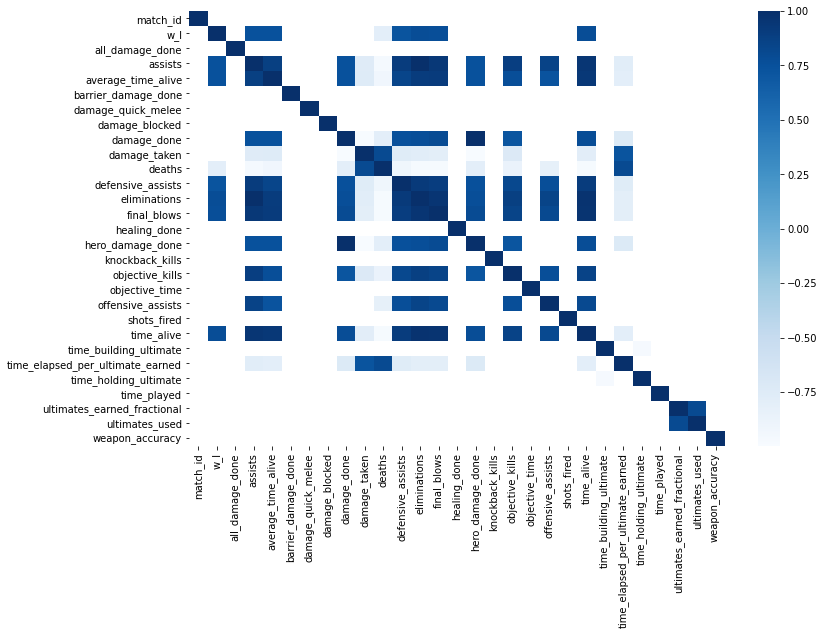

In [46]:
corr = df.corr()
best_corr = corr[abs(corr)>=.7]
plt.figure(figsize=(12,8))
sns.heatmap(best_corr, cmap="Blues")

In [48]:
from sklearn.model_selection import train_test_split
train_test = df[['w_l', 'time_alive', 'final_blows', 'eliminations', 'defensive_assists', 'deaths', 'average_time_alive', 'assists']]
x_train, x_test, y_train, y_test = train_test_split(train_test.drop('w_l', axis=1), train_test['w_l'], train_size=0.8, random_state=1)

In [49]:
# Get all match IDs in 2021
cur.execute("""
SELECT DISTINCT esports_match_id
FROM public.player_data_2021""")

all_match_ids_2021 = [x[0] for x in cur.fetchall()]
all_match_ids_2021 = sorted(all_match_ids_2021)

df_dict = dict.fromkeys(all_match_ids_2021, 0)

i = 1
for match_id in all_match_ids_2021:
    df_dict[match_id] = get_match_data(match_id, 2021)
    print(i, end=' ')
    i += 1

val = pd.DataFrame.from_dict(df_dict, orient='index', columns=cols)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 

,w_l,time_alive,final_blows,eliminations,defensive_assists,deaths,average_time_alive,assists
37147,1,23.12,1.99,11.61,8.43,-2.22,20.27,9.00
37148,1,1.16,-0.88,-0.48,-2.38,0.56,10.12,-1.19
37149,1,22.61,1.86,10.17,8.43,-2.17,21.26,7.94
37150,0,-15.41,-1.38,-4.74,-4.75,1.78,-28.66,-3.20
37211,1,8.65,0.77,1.70,2.82,-0.83,11.26,0.83


In [54]:
val.rename(mapper = lambda x: x.lower().replace(' - ', '_').replace(' ', '_'), axis=1, inplace=True)
val = val[['w_l', 'time_alive', 'final_blows', 'eliminations', 'defensive_assists', 'deaths', 'average_time_alive', 'assists']]
x_val = val.drop('w_l', axis=1)
y_val = val['w_l']

In [61]:
def evaluate(model_name, model, x_test, y_test, x_val, y_val):
    test_score = model.score(x_test, y_test)
    val_score = model.score(x_val, y_val)
    print(f"""
    {model_name}
    ----------------------
    Test Score: {round(test_score, 4)}
    Validation Score: {round(val_score, 4)}
    """)

log_model = LogisticRegression(solver='lbfgs', random_state = 1)
dt_model = DecisionTreeClassifier(random_state = 1)

rf_model = RandomForestClassifier(random_state = 1) 

evaluate('Logistic Regression', log_model.fit(x_train, y_train), x_test, y_test, x_val, y_val)
evaluate('Decision Tree', dt_model.fit(x_train, y_train), x_test, y_test, x_val, y_val)
evaluate('Random Forest', rf_model.fit(x_train, y_train), x_test, y_test, x_val, y_val)


    Logistic Regression
    ----------------------
    Test Score: 0.9423
    Validation Score: 0.9333
    

    Decision Tree
    ----------------------
    Test Score: 0.9038
    Validation Score: 0.94
    

    Random Forest
    ----------------------
    Test Score: 0.8846
    Validation Score: 0.9333
    
